<a href="https://colab.research.google.com/github/Ehsantba/Machine-Learning/blob/main/Biomedical_Signal_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomedical Signal Analysis
```
  __  __ _        _____           _           _   
 |  \/  | |      |  __ \         (_)         | |  
 | \  / | |      | |__) | __ ___  _  ___  ___| |_
 | |\/| | |      |  ___/ '__/ _ \| |/ _ \/ __| __|
 | |  | | |____  | |   | | | (_) | |  __/ (__| |_
 |_|  |_|______| |_|   |_|  \___/| |\___|\___|\__|
                                _/ |              
                               |__/               
```

In [1]:
!pip install -qq wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [3]:
import os
import wfdb
import zipfile
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
# Add other required imports here

#### Download the EMG data

In [4]:
url = "https://physionet.org/content/emgdb/get-zip/1.0.0/"
zip_file = "emgdb.zip"
if not os.path.exists(zip_file):
    response = requests.get(url)
    with open(zip_file, "wb") as f:
        f.write(response.content)

In [5]:
extract_path = "emgdb"
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(extract_path)

## Signal Processing

In [6]:
def bandpass_filter(signal, lowcut=20, highcut=450, fs=1000, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

## Feature Extraction

In [7]:
def extract_features(segment):
    return [
        np.mean(np.abs(segment)),         # MAV
        np.sqrt(np.mean(segment**2)),     # RMS
        np.var(segment),                  # Variance
        ((segment[:-1] * segment[1:]) < 0).sum()  # Zero crossings
    ]

## Load and Prepare the Data

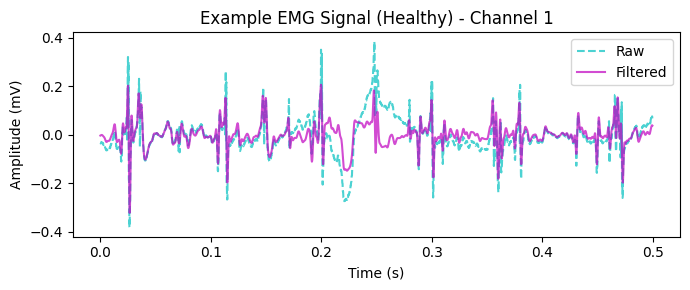

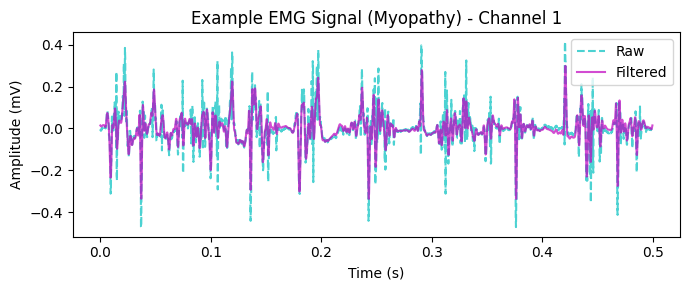

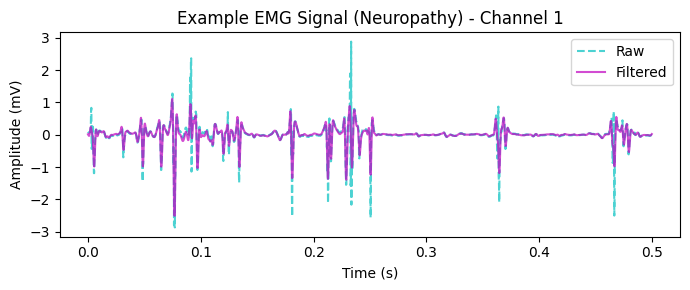

In [8]:
classes = {
    "emg_healthy": 0,
    "emg_myopathy": 1,
    "emg_neuropathy": 2
}
class_names = ["Healthy", "Myopathy", "Neuropathy"]

X, y = [], []
window_size = int(0.2 * 1000)  # 200 ms
step_size = window_size // 2

for folder, label in classes.items():
    subject_path = os.path.join(
        extract_path, "examples-of-electromyograms-1.0.0", folder
    )
    record = wfdb.rdrecord(subject_path)
    signals = record.p_signal
    fs = record.fs

    # Filter all channels
    signals_filt = np.array([bandpass_filter(ch, fs=fs) for ch in signals.T]).T

    # --- Plot for inspection (first channel, first few seconds) ---
    t = np.arange(len(signals)) / fs
    plt.figure(figsize=(7, 3))
    plt.plot(t[:2000], signals[:2000, 0], 'c--', label="Raw", alpha=0.7)
    plt.plot(t[:2000], signals_filt[:2000, 0], 'm', label="Filtered", alpha=0.7)
    plt.title(f"Example EMG Signal ({class_names[label]}) - Channel 1")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Extract features for classification
    for start in range(0, signals_filt.shape[0] - window_size, step_size):
        window = signals_filt[start:start+window_size, :]
        features = []
        for ch in range(window.shape[1]):
            features.extend(extract_features(window[:, ch]))
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

## Classification

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix , ConfusionMatrixDisplay


### 1. Data Preparation

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [11]:
X_train.shape, X_test.shape

((2468, 4), (618, 4))

In [12]:
print(X_train[:5])

[[1.08742219e-01 1.95005470e-01 3.79422090e-02 1.00000000e+01]
 [8.63229839e-02 2.19039391e-01 4.79472960e-02 1.30000000e+01]
 [4.38802154e-02 6.41250838e-02 4.11006796e-03 1.70000000e+01]
 [3.14085965e-02 4.40389979e-02 1.93504790e-03 1.30000000e+01]
 [5.52493491e-02 8.31407671e-02 6.91193801e-03 1.70000000e+01]]


### 2. Design and Train the Pipeline

In [13]:
model_pipeline = Pipeline([('scaler', StandardScaler()),
 ('classifier', RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1))])

In [14]:
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

### 3. Evaluation

In [15]:
y_pred = model_pipeline.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred, target_names=class_names))
print("-" * 40)


              precision    recall  f1-score   support

     Healthy       0.55      0.55      0.55       101
    Myopathy       0.84      0.87      0.86       221
  Neuropathy       0.90      0.87      0.89       296

    accuracy                           0.82       618
   macro avg       0.76      0.77      0.76       618
weighted avg       0.82      0.82      0.82       618

----------------------------------------


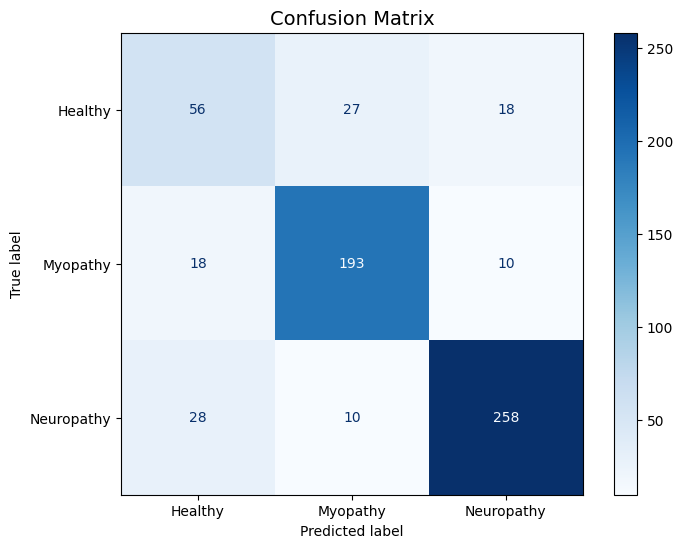

----------------------------------------


In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, cmap='Blues', ax=ax)
plt.title('Confusion Matrix', fontsize=14)
plt.show()
print("-" * 40)


##Keras

In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of y_train_one_hot:", y_train_one_hot.shape)

Shape of X_train_scaled: (2468, 4)
Shape of y_train_one_hot: (2468, 3)


In [20]:
model = Sequential([    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
Dropout(0.2),
Dense(3, activation='softmax')])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739 (2.89 KB)

 Trainable params: 739 (2.89 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4498 - loss: 1.1054 - val_accuracy: 0.7184 - val_loss: 0.8218
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6933 - loss: 0.8012 - val_accuracy: 0.7249 - val_loss: 0.6448
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6943 - loss: 0.6779 - val_accuracy: 0.7314 - val_loss: 0.5885
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7208 - loss: 0.6267 - val_accuracy: 0.7362 - val_loss: 0.5586
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7200 - loss: 0.5924 - val_accuracy: 0.7282 - val_loss: 0.5382
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7408 - loss: 0.5537 - val_accuracy: 0.7524 - val_loss: 0.5241
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7221 - loss: 0.5669 - val_accuracy: 0.7621 - val_loss: 0.5146
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7257 - loss: 0.5535 - val_accuracy: 0.7686 - val_loss:

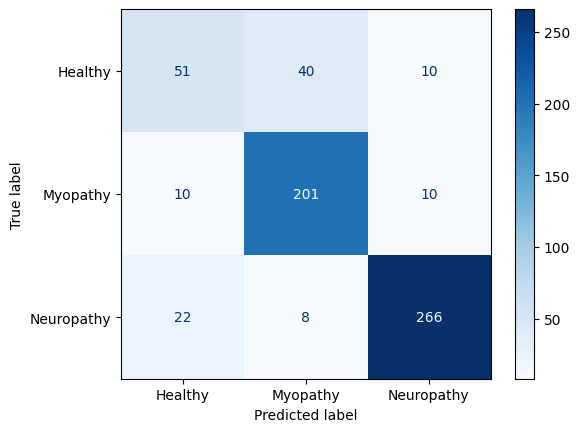

In [22]:
history = model.fit(X_train_scaled, y_train_one_hot,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test_one_hot),
                    verbose=1)

loss, accuracy = model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)


ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, display_labels=class_names, cmap='Blues')
plt.show()